In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [15]:
# Hyperparameters from the paper/our setup
SEQUENCE_LENGTH = 10
BATCH_SIZE = 128
NUM_EPOCHS = 500        
D_MODEL = 128           
N_HEADS = 4             
NUM_ENCODER_LAYERS = 3  
DROPOUT_RATE = 0.1      
LEARNING_RATE = 1e-4    
THRESHOLD_PERCENTILE = 95 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"--- Using {device.upper()} device for training and evaluation ---")

--- Using CUDA device for training and evaluation ---


In [14]:
# List of all data files to be loaded
files_to_load = [
    'train_basic.csv',
    'test_basic.csv',
    'train_semiurban.csv',
    'test_semiurban.csv',
    'test_rural.csv'
]

In [5]:
list_of_dfs = []
for filename in files_to_load:
    path = f"datasets/{filename}"
    try:
        df = pd.read_csv(path)
        # Optional: Add a column to track the origin of the data
        df['origin'] = filename.split('.')[0]
        list_of_dfs.append(df)
        print(f"Successfully loaded {filename}")
    except FileNotFoundError:
        print(f"Warning: Could not find file {filename}. Skipping.")

/tmp/ipykernel_810619/3454815949.py:5: DtypeWarning: Columns (0,304,307,344,347,397,398,399,400,401,402,413,414,423,424) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Successfully loaded train_basic.csv
Successfully loaded test_basic.csv


/tmp/ipykernel_810619/3454815949.py:5: DtypeWarning: Columns (0,201,205,212,213,233,237,241,245,256,259,275,280,283,307,328,331,336,339,355,370,374,379,380,382,387,388,389,390,391,392,393,394,395,396,400,401,402,404,405,406,407,408,409,410,411,412,413,414,417,418,421,422,423,424,425,426,427,428,429,430,431,432,442) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [6]:
for i in list_of_dfs:
    print(i.shape)

(43204, 473)
(43204, 473)


In [7]:
full_df = pd.concat(list_of_dfs, ignore_index=True)

In [8]:
def map_malicious_to_numeric(value):
    val_str = str(value).strip()
    if val_str == 'False': return 0
    elif 'benign' in val_str: return 1
    elif val_str.isdigit(): return 2
    else: return 0

full_df['malicious'] = full_df['malicious'].apply(map_malicious_to_numeric)

In [9]:
full_df.shape

(86408, 473)

In [10]:
# Remove constant numerical columns based on the full dataset
std_dev_full = full_df.std(numeric_only=True)
cols_to_drop = std_dev_full[std_dev_full == 0].index.tolist()

if cols_to_drop:
    print(f"Found and dropping {len(cols_to_drop)} constant numerical columns.")
    full_df = full_df.drop(columns=cols_to_drop)
else:
    print("No constant numerical columns found.")

Found and dropping 135 constant numerical columns.


In [11]:
full_df.shape

(86408, 338)

In [12]:
full_df['malicious'].value_counts()

malicious
0    80170
2     5745
1      493
Name: count, dtype: int64

In [13]:
# Unify all non-numeric columns to be strings
features_to_unify = full_df.select_dtypes(exclude=np.number).columns
features_to_unify = features_to_unify.drop('malicious', errors='ignore')

if not features_to_unify.empty:
    for col in features_to_unify:
        full_df[col] = full_df[col].astype(str)


In [15]:
# Create a Stratified Train/Test Split
X = full_df.drop(columns=['malicious'])
y = full_df['malicious']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,       # Use 30% of the data for testing
    random_state=42,     # For reproducible results
    stratify=y           
)

In [16]:
# Preprocess Data (Scale and Encode)
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()) # Using MinMaxScaler for [0, 1] range
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


In [17]:
# Fit the preprocessor on the new X_train and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [16]:
# Prepare Sequences for SUPERVISED Learning
def create_supervised_sequences(X_data, y_data, seq_len):
    sequences, labels = [], []
    for i in range(len(X_data) - seq_len):
        sequences.append(X_data[i:i + seq_len])
        labels.append(y_data.iloc[i + seq_len - 1])
    return np.array(sequences), np.array(labels)


In [19]:
X_train_seq, y_train_seq = create_supervised_sequences(X_train_processed, y_train, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_supervised_sequences(X_test_processed, y_test, SEQUENCE_LENGTH)


X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
# Define the Transformer Classifier Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, feature_size, d_model, n_heads, num_encoder_layers, num_classes, dropout_rate):
        super(TransformerClassifier, self).__init__()
        self.d_model = d_model
        self.input_embedding = nn.Linear(feature_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout_rate)
        encoder_layers = nn.TransformerEncoderLayer(d_model, n_heads, d_model * 4, dropout_rate, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.decoder = nn.Linear(d_model, num_classes)

    def forward(self, src):
        src = self.input_embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # We take the output of the last time step to represent the whole sequence
        prediction = self.decoder(output[:, -1, :])
        return prediction

In [21]:
# Train the Supervised Model

N_FEATURES = X_train_processed.shape[1]
NUM_CLASSES = len(y.unique())

model = TransformerClassifier(
    feature_size=N_FEATURES,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE
).to(device)

# Handling Class Imbalance
class_counts = y_train.value_counts().sort_index()
weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
weights = weights / weights.sum() # Normalize weights
criterion = nn.CrossEntropyLoss(weight=weights.to(device)) # Use class weights in loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Training 
print(f"\n--- Starting Supervised Transformer Model Training ({NUM_EPOCHS} Epochs) ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        outputs = model(seqs) # These are raw logits
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.6f}')
print("--- Training Complete ---")


--- Starting Supervised Transformer Model Training (500 Epochs) ---
Epoch [5/500], Loss: 0.658021
Epoch [10/500], Loss: 1.569908
Epoch [15/500], Loss: 0.541121
Epoch [20/500], Loss: 0.232988
Epoch [25/500], Loss: 0.230365
Epoch [30/500], Loss: 0.207012
Epoch [35/500], Loss: 0.465214
Epoch [40/500], Loss: 1.318161
Epoch [45/500], Loss: 0.100937
Epoch [50/500], Loss: 0.152453
Epoch [55/500], Loss: 0.237560
Epoch [60/500], Loss: 0.188413
Epoch [65/500], Loss: 0.089614
Epoch [70/500], Loss: 0.335368
Epoch [75/500], Loss: 0.190046
Epoch [80/500], Loss: 0.123128
Epoch [85/500], Loss: 0.102225
Epoch [90/500], Loss: 0.223132
Epoch [95/500], Loss: 0.107331
Epoch [100/500], Loss: 0.190896
Epoch [105/500], Loss: 0.104088
Epoch [110/500], Loss: 0.102881
Epoch [115/500], Loss: 0.043582
Epoch [120/500], Loss: 0.299565
Epoch [125/500], Loss: 0.073645
Epoch [130/500], Loss: 0.273023
Epoch [135/500], Loss: 0.041130
Epoch [140/500], Loss: 0.130231
Epoch [145/500], Loss: 0.045980
Epoch [150/500], Loss: 


--- Evaluating Classifier on the Test Set ---

--- Final Classification Report (Transformer Classifier) ---
              precision    recall  f1-score   support

  Normal (0)       0.98      0.98      0.98     39422
  Benign (1)       0.83      0.78      0.81       529
  Attack (2)       0.87      0.89      0.88      5499

    accuracy                           0.97     45450
   macro avg       0.89      0.88      0.89     45450
weighted avg       0.97      0.97      0.97     45450


--- Final Confusion Matrix ---


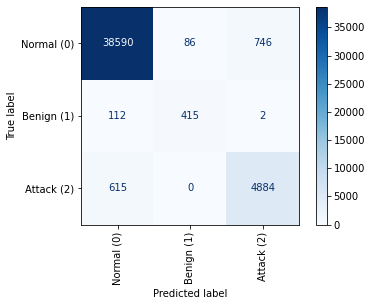

In [22]:
# Evaluation
print("\n--- Evaluating Classifier on the Test Set ---")
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for seqs, labels in test_loader:
        seqs = seqs.to(device)
        outputs = model(seqs)
        # Get predictions by finding the class with the highest score (logit)
        _, predicted_labels = torch.max(outputs, 1)
        all_preds.extend(predicted_labels.cpu().numpy())
        all_true.extend(labels.numpy())



# Generate the final report and confusion matrix
target_names = ['Normal (0)', 'Benign (1)', 'Attack (2)']
print("\n--- Final Classification Report (Transformer Classifier) ---")
print(classification_report(all_true, all_preds, target_names=target_names))

print("\n--- Final Confusion Matrix ---")
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()